In [1]:
import os
os.chdir("..")

In [2]:
import world_bank_data as wb
import pandas as pd
import polars as pl
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.data.data_pull import DataClean

dc = DataClean()

In [ ]:
df = dc.pull_wb()

In [11]:
columns = [
    'gdp_growth', 'spending', 'gini',
    'expenses'
]
data = df.to_pandas()

# Step 1: Sort the DataFrame
data = data[data["country"] != "World"]
data = data[data["country"] == "United States"]
data = data.sort_values(by=['year', 'country']).reset_index(drop=True)

# Step 2: Interpolate each column by zip group
# data[columns] = data.groupby('country')[columns].transform(
#     lambda group: group.interpolate(method='linear', limit_direction='both')
# )
data = data.dropna(subset=["gdp_growth"]).reset_index(drop=True)
data = data.dropna(subset=["expenses"]).reset_index(drop=True)
data

,year,country,gdp,gdp_growth,spending,gini,expenses
0,2012,United States,1.625397e+13,2.289113,15.475843,40.900002,23.911903
1,2013,United States,1.688068e+13,2.117830,14.991959,40.599998,22.881464
2,2014,United States,1.760814e+13,2.523820,14.551658,41.500000,22.610073
3,2015,United States,1.829502e+13,2.945550,14.233316,41.200001,22.373535
4,2016,United States,1.880491e+13,1.819451,14.110004,41.099998,22.415922
5,2017,United States,1.961210e+13,2.457622,13.847134,41.200001,22.140699
6,2018,United States,2.065652e+13,2.966505,13.844213,41.400002,22.169479
7,2019,United States,2.153998e+13,2.583825,13.983559,41.500000,22.514338
8,2020,United States,2.135411e+13,-2.163029,14.895745,39.700001,31.828148
9,2021,United States,2.368117e+13,6.055053,14.253033,39.700001,31.303476


In [12]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

In [16]:
num_knots = 5
knots = np.quantile(data["expenses"], np.linspace(0, 1, num_knots))
iknots = knots[1:-1]
priors = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=10),
    "common": bmb.Prior("Normal", mu=0, sigma=10), 
    "sigma": bmb.Prior("Exponential", lam=1)
}
model = bmb.Model("gdp_growth ~ year + bs(expenses, knots=iknots, intercept=True)", data, dropna=True, priors=priors)

In [17]:
def plot_spline_basis(basis, expenses, figsize=(10, 6)):
    df = (
        pd.DataFrame(basis)
        .assign(expenses=expenses)
        .melt("expenses", var_name="basis_idx", value_name="gdp_growth")
    )

    _, ax = plt.subplots(figsize=figsize)

    for idx in df.basis_idx.unique():
        d = df[df.basis_idx == idx]
        ax.plot(d["expenses"], d["gdp_growth"])
    
    return ax

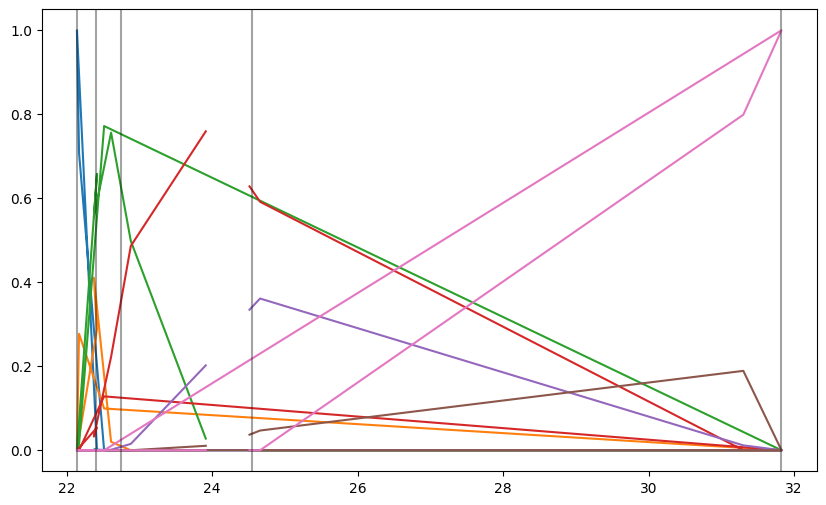

In [18]:
B = model.components["mu"].design.common["bs(expenses, knots=iknots, intercept=True)"]
ax = plot_spline_basis(B, data["expenses"].values)
plot_knots(knots, ax);

In [ ]:
# The seed is to make results reproducible
idata = model.fit(idata_kwargs={"log_likelihood": True})

In [ ]:
az.plot_trace(idata);

In [ ]:
posterior_stacked = az.extract(idata)
wp = posterior_stacked["bs(expenses, knots=iknots, intercept=True)"].mean("sample").values

ax = plot_spline_basis(B * wp.T, data["expenses"].values)
ax.plot(data.expenses.values, np.dot(B, wp.T), color="black", lw=3)
plot_knots(knots, ax);